## My Project

In [9]:
import torch
print(torch.__version__)
print('cuda available with GPU:',torch.cuda.get_device_name(0))
!nvcc --version

1.10.0+cu111
cuda available with GPU: Tesla K80
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# Please rename according to google drive directory
os.chdir('/content/gdrive/MyDrive/CS5242/MyProject')
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/CS5242/MyProject


In [ ]:
# Import user functions
%load_ext autoreload
%autoreload 2
from networks.mlp_net import MLP

In [10]:
# GPU Setup
if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('cuda not available')
    device = torch.device('cpu')

cuda available with GPU: Tesla K80


### EDA (Resize using torchvision)

In [11]:
import torchvision as tv
import matplotlib.pyplot as plt

In [28]:
# "tv data" is a directory containing 2 folders mask and no_mask which contains jpeg images of the respective classes.

sample = tv.datasets.ImageFolder(root="./tv data", transform=tv.transforms.ToTensor())
sample = iter(sample)

resize = tv.transforms.Compose(
    [tv.transforms.Resize(224), tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]
)
sample_resized = tv.datasets.ImageFolder(root="./tv data", transform=resize)
sample_resized = iter(sample_resized)

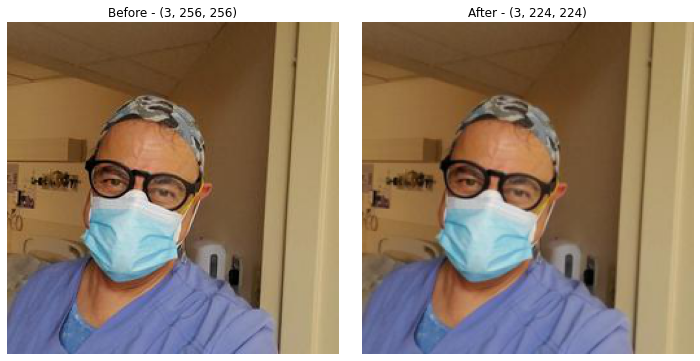

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_resized = next(iter(sample_resized))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_resized.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_resized.shape)}")
plt.tight_layout()

### EDA (Data Augmentation)

In [43]:
augment = tv.transforms.Compose(
    [
        tv.transforms.RandomResizedCrop(256),
        tv.transforms.RandomHorizontalFlip(p=0.25),
        tv.transforms.RandomVerticalFlip(p=0.25),
        tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        tv.transforms.ToTensor(),
    ]
)

In [44]:
sample = tv.datasets.ImageFolder(root="./tv data", transform=tv.transforms.ToTensor())
sample_augmented = tv.datasets.ImageFolder(root="./tv data", transform=augment)

In [45]:
sample = iter(sample)
sample_augmented = iter(sample_augmented)

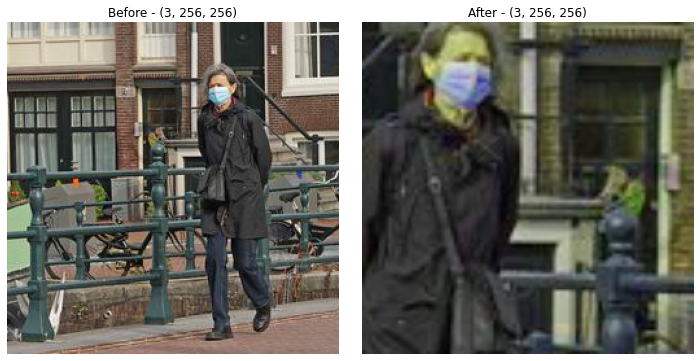

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image = next(iter(sample))[0]
image_augmented = next(iter(sample_augmented))[0]

ax[0].imshow(image.permute(1, 2, 0))
ax[0].axis("off")
ax[0].set_title(f"Before - {tuple(image.shape)}")
ax[1].imshow(image_augmented.permute(1, 2, 0))
ax[1].axis("off")
ax[1].set_title(f"After - {tuple(image_augmented.shape)}")
plt.tight_layout()

### 3 Layer MLP

In [30]:
data_path='Data/CleanerV2/'

train_data = torch.load(data_path+'training_data_bw.pt').squeeze(dim=1)
train_label =  torch.load(data_path+'training_labels_bw.pt').squeeze(dim=1)
test_data = torch.load(data_path+'testing_data_bw.pt').squeeze(dim=1)
test_label = torch.load(data_path+'testing_labels_bw.pt').squeeze(dim=1)

print(train_data.size(),train_label.size(),test_data.size(),test_label.size())

torch.Size([3381, 28, 28]) torch.Size([3381]) torch.Size([1461, 28, 28]) torch.Size([1461])


In [5]:
import torch.nn as nn

def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data 

In [6]:
def sigma(x):
    return ( 2*torch.exp(x) - torch.exp(-x) ) / ( 2*torch.exp(x) + torch.exp(-x) )

class three_layer_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(three_layer_MLP , self).__init__()
        self.layer1 = nn.Linear(  input_size, hidden_size )
        self.layer2 = nn.Linear(  hidden_size, hidden_size )
        self.layer3 = nn.Linear(  hidden_size, output_size )
    def forward(self, x):
        x = self.layer1(x)
        x = sigma(x)
        x = self.layer2(x)
        x = sigma(x)
        score = self.layer3(x)
        return score

net = three_layer_MLP(784,25,10)
print(net)

bs = 100
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam( net.parameters() , lr=0.01 )

for epoch in range(10):
    running_loss=0
    running_acc=0
    num_batches=0
    shuffled_indices=torch.randperm(1000)
    for count in range(0,1000,bs):
        optimizer.zero_grad()
        indices = shuffled_indices[count:count+bs]
        minibatch_data = train_data[indices]
        minibatch_label = train_label[indices]
        inputs = minibatch_data.view(bs,784)
        inputs.requires_grad_()
        scores = net(inputs) 
        loss = criterion(scores, minibatch_label) 
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        acc = get_accuracy( scores.detach() , minibatch_label)
        running_acc += acc.item()
        num_batches+=1
    total_loss = running_loss/num_batches
    total_acc = running_acc/num_batches
    print("Epoch={}, Train loss={}, Train accuracy={}".format(epoch+1, total_loss, total_acc))
    
net.eval()
with torch.no_grad():
    data = test_data.view(-1,784)
    labels = test_label
    scores = net(data) 
    print("Test accuracy={}".format(get_accuracy(scores.detach(),labels)))


three_layer_MLP(
  (layer1): Linear(in_features=784, out_features=25, bias=True)
  (layer2): Linear(in_features=25, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=10, bias=True)
)
Epoch=1, Train loss=0.621454768255353, Train accuracy=90.0
Epoch=2, Train loss=0.016758081037551165, Train accuracy=100.0
Epoch=3, Train loss=0.0033379984786733987, Train accuracy=100.0
Epoch=4, Train loss=0.0016815850278362632, Train accuracy=100.0
Epoch=5, Train loss=0.0012245694524608552, Train accuracy=100.0
Epoch=6, Train loss=0.001036487880628556, Train accuracy=100.0
Epoch=7, Train loss=0.0009327325329650194, Train accuracy=100.0
Epoch=8, Train loss=0.0008602047397289425, Train accuracy=100.0
Epoch=9, Train loss=0.0008012148784473539, Train accuracy=100.0
Epoch=10, Train loss=0.0007492537726648152, Train accuracy=100.0
Test accuracy=64.47638702392578


In [7]:
data_path='Data/CleanerV2/'

train_data = torch.load(data_path+'training_data_color.pt').squeeze(dim=1)
train_label =  torch.load(data_path+'training_labels_color.pt').squeeze(dim=1)
test_data = torch.load(data_path+'testing_data_color.pt').squeeze(dim=1)
test_label = torch.load(data_path+'testing_labels_color.pt').squeeze(dim=1)

print(train_data.size(),train_label.size(),test_data.size(),test_label.size())

torch.Size([3381, 3, 28, 28]) torch.Size([3381]) torch.Size([1461, 3, 28, 28]) torch.Size([1461])


In [ ]:
# Saving checkpoint
import time
MODEL_NAME = 'MLP'
DATASET_NAME = 'MNIST'
out_dir = 'out/classification/'
root_ckpt_dir = out_dir + 'checkpoints/' + MODEL_NAME + "_" + DATASET_NAME + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
print(ckpt_dir)

model = MLP(784,10)
epoch = 100

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))
